In [1]:
import sys
sys.path.append(r'E:\Users\lzk26\Desktop\YoloV8-Pose-Keypoint-Classification-master')  # 添加上级目录到搜索路径


from models.exception_detect import Autoencoder

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Read Dataset

In [3]:
df = pd.read_csv('../datasets/train/CPRnew.csv')
df.head()

,image_name,label,x1,y1,z1,x2,y2,z2,x3,y3,...,z30,x31,y31,z31,x32,y32,z32,x33,y33,z33
0,182A3660AF4757F9B164F039EF7B89C2.jpg,CPR,0.381816,0.320225,0.571344,0.394085,0.323278,0.590485,0.395196,0.320854,...,0.677188,0.092028,0.280969,0.351784,0.058296,0.295819,0.642075,0.055537,0.296076,0.391665
1,41DB4441D3A3FEBB8AA049D09A8236F9.jpg,CPR,0.278908,0.158239,0.282351,0.283780,0.148759,0.287443,0.287904,0.145746,...,0.756329,0.274332,0.172171,0.704101,0.293284,0.190471,0.719233,0.262889,0.187554,0.690123
2,4536CBF559B6B41CFFDD9576E47BBB0F.jpg,CPR,0.142329,0.223197,0.633063,0.128631,0.224503,0.633914,0.127296,0.221443,...,0.515017,0.385163,0.238695,0.544445,0.388453,0.280226,0.509592,0.404175,0.272078,0.540276
3,4B50EFF7750C1C9FC2747310ECE5CB53.jpg,CPR,0.353866,0.374913,0.621381,0.362183,0.371581,0.635273,0.362273,0.367024,...,0.538286,0.097512,0.336250,0.281341,0.035991,0.350486,0.499007,0.047726,0.355841,0.317901
4,4C13D0B43AC87E0A1CD84FA4368265FE.jpg,CPR,0.127710,0.231646,0.567221,0.118625,0.234499,0.569480,0.118139,0.232458,...,0.535800,0.280168,0.175135,0.530863,0.297367,0.200831,0.526554,0.296409,0.177353,0.534234


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Columns: 101 entries, image_name to z33
dtypes: float64(99), object(2)
memory usage: 271.6+ KB


## Train Test Split

In [5]:
# encoder label
encoder = LabelEncoder()
y_label = df['label']
y = encoder.fit_transform(y_label)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [6]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights

array([1.])

In [7]:
# Get keypoint dataset
X = df.iloc[:,2:]
X

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z30,x31,y31,z31,x32,y32,z32,x33,y33,z33
0,0.381816,0.320225,0.571344,0.394085,0.323278,0.590485,0.395196,0.320854,0.590442,0.396254,...,0.677188,0.092028,0.280969,0.351784,0.058296,0.295819,0.642075,0.055537,0.296076,0.391665
1,0.278908,0.158239,0.282351,0.283780,0.148759,0.287443,0.287904,0.145746,0.287419,0.291916,...,0.756329,0.274332,0.172171,0.704101,0.293284,0.190471,0.719233,0.262889,0.187554,0.690123
2,0.142329,0.223197,0.633063,0.128631,0.224503,0.633914,0.127296,0.221443,0.633923,0.125778,...,0.515017,0.385163,0.238695,0.544445,0.388453,0.280226,0.509592,0.404175,0.272078,0.540276
3,0.353866,0.374913,0.621381,0.362183,0.371581,0.635273,0.362273,0.367024,0.635268,0.362100,...,0.538286,0.097512,0.336250,0.281341,0.035991,0.350486,0.499007,0.047726,0.355841,0.317901
4,0.127710,0.231646,0.567221,0.118625,0.234499,0.569480,0.118139,0.232458,0.569486,0.117403,...,0.535800,0.280168,0.175135,0.530863,0.297367,0.200831,0.526554,0.296409,0.177353,0.534234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0.707798,0.472260,-0.098893,0.707129,0.449907,-0.079662,0.705557,0.448462,-0.079853,0.703407,...,0.414447,0.280550,0.819540,0.073507,0.334097,0.867496,0.477626,0.278906,0.873220,0.180079
340,0.705350,0.464763,-0.091908,0.704488,0.442987,-0.072466,0.702949,0.441648,-0.072651,0.700846,...,0.420000,0.280710,0.819605,0.062828,0.329176,0.866232,0.483477,0.278243,0.874301,0.179494
341,0.704327,0.461546,-0.092633,0.703540,0.439770,-0.073156,0.702035,0.438443,-0.073344,0.700007,...,0.429558,0.292005,0.819552,0.061225,0.322560,0.864216,0.491720,0.276860,0.874535,0.173838
342,0.696380,0.448736,-0.069044,0.695181,0.425573,-0.048449,0.693774,0.424207,-0.048634,0.691806,...,0.410508,0.281763,0.818610,0.015062,0.257871,0.867296,0.463505,0.259115,0.880835,0.130772


In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=2022)

print("Number of Training keypoints: ", len(X_train))
print("Number of Testing keypoints: ", len(X_test))

Number of Training keypoints:  275
Number of Testing keypoints:  69


In [9]:
scaler = MinMaxScaler()

In [10]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test

array([[0.2626285 , 0.29795256, 0.91928299, ..., 0.7598221 , 0.54688834,
        0.26470245],
       [0.11194946, 0.27008691, 0.61733094, ..., 0.30145641, 0.26574646,
        0.54244332],
       [0.70550591, 0.41994166, 0.07476002, ..., 0.23669796, 0.87444864,
        0.09225646],
       ...,
       [0.00611918, 0.09855729, 0.64445473, ..., 0.08453982, 0.02600668,
        0.45136549],
       [0.7128135 , 0.47455457, 0.0289009 , ..., 0.24063546, 0.84221972,
        0.09839106],
       [0.42521095, 0.29997724, 0.13908491, ..., 0.46471941, 0.56320715,
        0.75617975]])

## Data Loader

In [11]:
class DataKeypointClassification(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
        self.n_samples = X.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [12]:
train_dataset = DataKeypointClassification(X_train, y_train)
test_dataset = DataKeypointClassification(X_test, y_test)

In [13]:
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Model

In [14]:
# 初始化自编码器模型
input_size = X_train.shape[1]
hidden_size = 256
model = Autoencoder(input_size, hidden_size)


In [15]:
# 初始化自编码器模型
input_size = X_train.shape[1]
hidden_size = 256
model = Autoencoder(input_size, hidden_size)

## Loss & Optimizer

In [16]:
learning_rate = 0.01
# 使用MSE作为损失函数，因为我们的任务是重构输入
criterion = nn.MSELoss()
#criterion = nn.BCELoss()

# 保持使用Adam优化器，但仅调整学习率参数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


## Training

In [17]:
num_epoch = 100
for epoch in range(num_epoch):
    train_loss = 0
    loop = tqdm(train_loader)
    for idx, (inputs, _) in enumerate(loop):  # 不再需要标签
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # 使用输入和重构输出来计算损失

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{num_epoch}]")
        loop.set_postfix(loss=loss.item())


Epoch [100/100]: 100%|██████████| 23/23 [00:00<00:00, 48.94it/s, loss=0.00123]


## Test Model

In [18]:
with torch.no_grad():
    reconstruction_errors = []
    for inputs, _ in train_loader:
        outputs = model(inputs)
        mse = ((inputs - outputs) ** 2).mean(1)  # 计算每个样本的MSE
        reconstruction_errors.extend(mse.tolist())

# 计算平均值和标准差
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

# 计算阈值
threshold = mean_error + 2 * std_error
print("Suggested threshold:", threshold)


Suggested threshold: 0.02245202411821417


In [19]:
test_features = torch.from_numpy(X_test.astype(np.float32))

# 不需要标签进行异常检测
with torch.no_grad():
    reconstructed = model(test_features)
    # 计算重构误差
    reconstruction_error = ((test_features - reconstructed) ** 2).mean(1)
    # 异常样本的重构误差会大于阈值
    anomalies = reconstruction_error > threshold

# 将anomalies转换为预期的格式进行进一步分析或报告
anomalies = anomalies.numpy().astype(int)


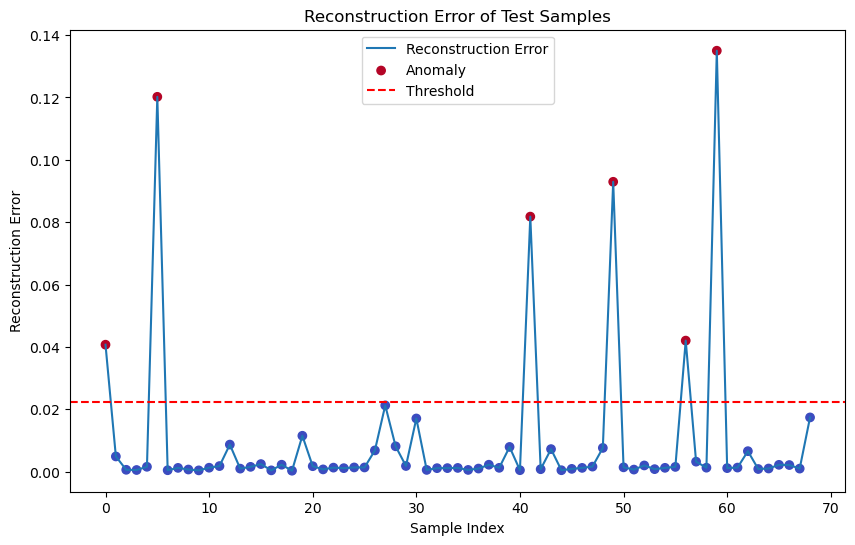

In [20]:
import matplotlib.pyplot as plt

# 绘制重构误差
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error.numpy(), label='Reconstruction Error')
# 标记被识别为异常的样本
plt.scatter(range(len(reconstruction_error)), reconstruction_error.numpy(), c=anomalies, cmap='coolwarm', label='Anomaly')

plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error of Test Samples')
plt.legend()
plt.show()


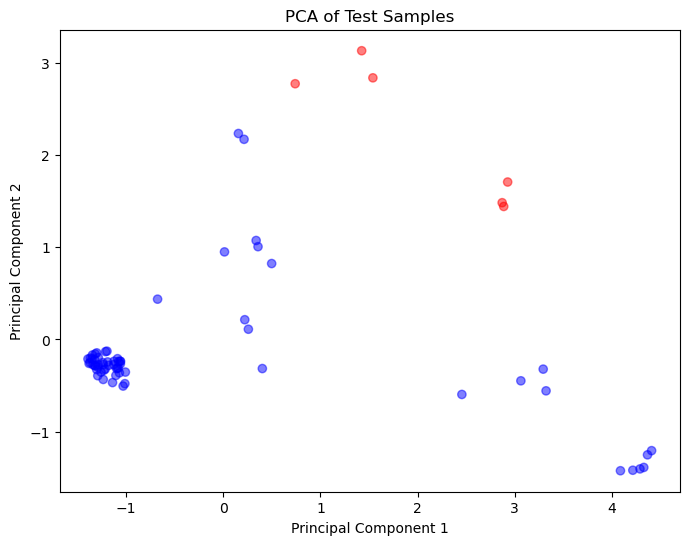

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test.astype(np.float32))

# 根据anomalies标记来选择颜色
colors = ['blue' if x == 0 else 'red' for x in anomalies]

plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=colors, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Test Samples')
plt.show()


## save model


In [22]:
PATH_SAVE = '../models/pose_classification.pt'
torch.save(model.state_dict(), PATH_SAVE)

## Load Inference Model

In [23]:
# 假设自编码器的结构已经被定义为Autoencoder类
model_inference = Autoencoder(
    input_size=X_train.shape[1], 
    hidden_size=hidden_size
)

# 加载模型状态
model_inference.load_state_dict(
    torch.load(PATH_SAVE, map_location=device)
)


<All keys matched successfully>

In [24]:
feature, _ = test_dataset.__getitem__(5)  # 假设标签不用于异常检测

# 确保feature是批量处理的格式，即[batch_size, input_size]
feature = feature.unsqueeze(0)

with torch.no_grad():
    reconstructed = model_inference(feature)
    # 计算重构误差，这里使用均方误差作为例子
    reconstruction_error = ((feature - reconstructed) ** 2).mean().item()

# 比较重构误差与阈值
threshold = 0.003676584281066375  # 使用之前确定的阈值
is_anomaly = reconstruction_error > threshold

print(f'Reconstruction Error: {reconstruction_error}')
print('This sample is', 'an Anomaly' if is_anomaly else 'Normal')


Reconstruction Error: 0.09798569232225418
This sample is an Anomaly
